In [1]:
import pandas as pd
import os
import random
import chardet
import requests
import json
import numpy as np
from urllib3.util.retry import Retry
import openai
from requests.adapters import HTTPAdapter
import os
import pickle
import matplotlib.pyplot as plt

In [2]:
with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-film\Emotion_scores\scores_allMovies_resample.pkl', 'rb') as f:
    scores_dict = pickle.load(f)
# del scores_dict['BV1zW411d7Rb']
with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-film\Emotion_scores\times_allMovies_resample.pkl', 'rb') as f:
    time_dict= pickle.load(f)
# del time_dict['BV1zW411d7Rb']

print(len(scores_dict.keys()))
print(len(time_dict.keys()))

102
102


In [3]:
scores_all = np.zeros((0,6))
n_samples = []

scores_key = list(scores_dict.keys())
count = 0
for key in scores_key:
    print(scores_dict[key].shape)
    scores_all = np.concatenate((scores_all, scores_dict[key]), 0)
    n_samples.append(scores_dict[key].shape[0])
    count += 1
print(scores_all.shape)
n_samples_cum = np.concatenate((np.array([0]), np.cumsum(n_samples)))
print(n_samples_cum[-5:])

(4565, 6)
(3699, 6)
(4218, 6)
(1158, 6)
(3955, 6)
(3907, 6)
(4714, 6)
(3192, 6)
(2984, 6)
(3800, 6)
(3051, 6)
(3007, 6)
(4277, 6)
(5197, 6)
(3371, 6)
(3058, 6)
(3692, 6)
(3824, 6)
(3642, 6)
(3513, 6)
(6846, 6)
(2616, 6)
(2717, 6)
(3223, 6)
(3500, 6)
(4148, 6)
(3174, 6)
(3960, 6)
(3516, 6)
(3088, 6)
(4303, 6)
(2692, 6)
(4010, 6)
(2179, 6)
(2700, 6)
(4200, 6)
(3530, 6)
(3611, 6)
(3210, 6)
(4031, 6)
(3293, 6)
(4606, 6)
(5233, 6)
(3487, 6)
(4200, 6)
(3405, 6)
(4484, 6)
(3562, 6)
(3987, 6)
(4766, 6)
(3337, 6)
(2703, 6)
(2995, 6)
(2522, 6)
(4044, 6)
(3547, 6)
(3019, 6)
(2789, 6)
(1396, 6)
(3753, 6)
(3557, 6)
(4445, 6)
(5073, 6)
(3361, 6)
(3299, 6)
(3914, 6)
(2651, 6)
(2634, 6)
(3734, 6)
(3296, 6)
(5312, 6)
(4252, 6)
(2729, 6)
(2721, 6)
(3117, 6)
(2910, 6)
(4223, 6)
(2703, 6)
(3214, 6)
(3854, 6)
(3990, 6)
(3631, 6)
(3372, 6)
(2874, 6)
(3032, 6)
(2207, 6)
(3129, 6)
(2081, 6)
(2788, 6)
(2601, 6)
(4910, 6)
(3071, 6)
(1895, 6)
(4002, 6)
(4031, 6)
(3191, 6)
(2957, 6)
(3355, 6)
(2830, 6)
(3452, 6)


In [4]:
print(scores_key)

['Batman_darknight', 'Be_somebody', 'forrest_gump', 'Gashapon', 'Godzilla', 'Green_book', 'Harry_potter', 'Heidi', 'Kong_fu', 'let_bullet_fly_reorder', 'Luo_xiao_hei', 'The_bad_guys', 'The_Shawshank_Redemption', 'The_Wandering_Earth_II', 'Weathering_With_You', 'White_snake', 'World_War_Z', 'Yang_jian', 'BV1134y1g7Vq', 'BV11x4y117NY', 'BV147411y71D', 'BV14b411c72z', 'BV14E411C7Lf', 'BV14T4y1u7ST', 'BV163411i7Un', 'BV164411k73g', 'BV16e4y1P7sa', 'BV17f4y1n7et', 'BV17h411D7aX', 'BV17W411r78v', 'BV17W411Z7Lh', 'BV18E411e7By', 'BV191421B7B9', 'BV19x41127Nd', 'BV1BJ411S7Ch', 'BV1bL411578p', 'BV1bz4y1a7QZ', 'BV1cW411a7ed', 'BV1Ds411V7cP', 'BV1dU4y1g73N', 'BV1Dx411u7jw', 'BV1e4411k74a', 'BV1E4411U7Qu', 'BV1ED4y1j7Jn', 'BV1Ee4y1B74h', 'BV1eJ411B7to', 'BV1Fb411F7fk', 'BV1Fb411z7Zy', 'BV1ht4y1D7tG', 'BV1j4411X7CV', 'BV1j44y1y7YQ', 'BV1kJ411j7pH', 'BV1kK4y1b7dH', 'BV1Kx411p7hz', 'BV1ky4y167Tg', 'BV1Lp411R7Fx', 'BV1LP4y1H7TJ', 'BV1M7411J7kP', 'BV1ms411U75B', 'BV1mw4m1e7BD', 'BV1na4y1Y7rR', 'BV1NE41

In [5]:
def read_scores(file_name, danmudir='data/movie_batch1', datadir='results/prompt_v4/movie_batch1'):
    with open(os.path.join(danmudir, 'danmu_%s_downsample.pkl' % file_name), 'rb') as f:
        danmu_dict = pickle.load(f)
    if file_name == 'forrest_gump':
        time_ranges = danmu_dict['阿甘正传.csv_time_range']
    else:
        time_ranges = danmu_dict['%s.csv_time_range' % file_name]
    
    time_points = np.zeros(len(time_ranges))
    for i in range(len(time_points)):
        time_points[i] = np.mean(time_ranges[i])

    datadir = os.path.join(datadir, file_name)
    file_names2 = os.listdir(datadir)
    n_files = len(file_names2)
    scores_all = np.zeros((n_files, 6))
    for count in range(len(time_ranges)):
        file_score = '%.3f_%.3f.json' % (time_ranges[count][0], time_ranges[count][1])
        # print(count,file_score)
        with open(os.path.join(datadir, file_score), 'r', encoding='utf-8') as file_score:
            data = json.load(file_score)

        # 提取 "content" 字段中的文本
        content = data['choices'][0]['message']['content']
        # print(content)

        # 解析文本，将情绪评分提取到列表中
        emotions = ["高兴", "惊讶", "悲伤", "愤怒", "厌恶", "恐惧"]
        scores = []

        # 拆分 content 字符串，并提取每个情绪的评分
        for emotion in emotions:
            start = content.find(emotion) + len(emotion) + 2
            end = content.find(";", start)
            if end == -1:  # 最后一个情绪评分后没有分号
                end = content.find('\n', start)
                if end == -1:
                    end = content.find(' ', start)
                    if end == -1:
                        end = len(content)
            # print(start, end)
            # score = int(content[start:end].strip().rstrip('.'))
            # score = int(content[start:end].strip())
            try:
                score = float(content[start:end].strip())
            except:
                if content[start] == '[':
                    score = float(content[start+1:end-1].strip())
                elif content[end-1]=='.':
                    score = float(content[start:end].strip()[:-1])
                elif content[end-1]=='。':
                    score = float(content[start:end].strip()[:-1])
                else:
                    try:
                        score = float(content[start:end].split('，')[0])
                    except:
                        score = float(content[start:end].split('；')[0])
            scores.append(score)
            
        scores_all[count] = np.array(scores)
        
    return scores_all, time_points

def smooth_scores(preds, time_points, smooth_win=10):
    half_win = int(round(smooth_win/2))
    preds_smoothed = np.zeros(preds.shape)
    for i in range(preds.shape[0]):
        preds_smoothed[i,:] = np.mean(preds[abs(time_points[:preds.shape[0]] - time_points[:preds.shape[0]][i]) <= half_win, :], axis=0)
    return preds_smoothed
        

def plot_scores(preds_smoothed, time_points, ylim=[0,7]):
    colors = ['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b']
    emos = ["Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear"]

    plt.figure(figsize=(15, 12))
    for j in range(6):
        plt.subplot(6,1,j+1)
        plt.plot(time_points[:preds_smoothed.shape[0]], preds_smoothed[:,j], color=colors[j], linewidth=0.7)
        plt.xlim([0,max(time_points)])
        plt.ylim(ylim)
        plt.ylabel('Scores')
        plt.xlabel('Time/s')
        plt.title(emos[j])

    # 调整布局
    plt.tight_layout()
    # plt.savefig('figures/prompt_v4_gpt4o_longMovie_lineplot.jpg', dpi=300)
    plt.show()

Explained variance ratio: [0.49378133 0.19681466 0.16693501 0.08574263 0.03698317 0.01974321]


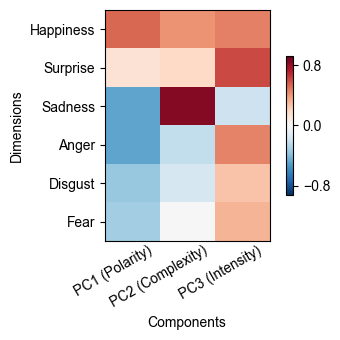

In [6]:
from sklearn.decomposition import PCA
import matplotlib
emos = ["Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear"]
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(preds_all)

# 创建PCA对象，设定要保留的主成分数量（例如：2个主成分）
pca = PCA(n_components=6)

# 使用PCA降维
X_pca = pca.fit_transform(scores_all)

# 解释方差比例（每个主成分解释的方差占总方差的比例）
print("Explained variance ratio:", pca.explained_variance_ratio_)

pca.components_[[3,4],:] = -pca.components_[[3,4],:]

matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(figsize=(4,3.5))
cax = ax.imshow(pca.components_.transpose()[:,:3],cmap='RdBu_r')
ax.set_aspect(0.7)
plt.xticks(np.arange(0.4,3.4,1),['PC1 (Polarity)', 'PC2 (Complexity)', 'PC3 (Intensity)'], rotation=30, ha='right')
plt.gca().tick_params(axis='x', pad=2)
plt.tick_params(axis='x', length=0)
plt.yticks(np.arange(6), emos)
plt.xlabel('Components')
plt.ylabel('Dimensions')
cbar = plt.colorbar(cax, shrink=0.6)
cbar.set_ticks([-0.8, 0.0, 0.8])
# max_lim = np.maximum(np.nanmax(pca.components_), -np.nanmin(pca.components_))
cax.set_clim([-0.921, 0.921])
# print(max_lim)
plt.tight_layout()
plt.savefig('figures/pca_scores_danmu_all_PC3.svg', dpi=300, bbox_inches='tight')
plt.show()

Explained variance ratio: [0.49378133 0.19681466 0.16693501 0.08574263 0.03698317 0.01974321]


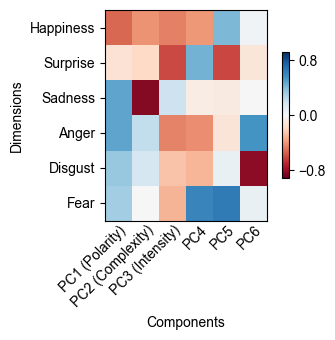

In [7]:
from sklearn.decomposition import PCA
import matplotlib
emos = ["Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear"]
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(preds_all)

# 创建PCA对象，设定要保留的主成分数量（例如：2个主成分）
pca = PCA(n_components=6)

# 使用PCA降维
X_pca = pca.fit_transform(scores_all)

# 解释方差比例（每个主成分解释的方差占总方差的比例）
print("Explained variance ratio:", pca.explained_variance_ratio_)

pca.components_[[3,4],:] = -pca.components_[[3,4],:]

matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(figsize=(4,3.5))
cax = ax.imshow(-pca.components_.transpose(),cmap='RdBu')
ax.set_aspect(1.3)
plt.xticks(np.arange(0.4,6.4,1),['PC1 (Polarity)', 'PC2 (Complexity)', 'PC3 (Intensity)', 'PC4', 'PC5', 'PC6'], rotation=45, ha='right')
plt.gca().tick_params(axis='x', pad=2)
plt.tick_params(axis='x', length=0)
plt.yticks(np.arange(6), emos)
plt.xlabel('Components')
plt.ylabel('Dimensions')
cbar = plt.colorbar(cax, shrink=0.6)
cbar.set_ticks([-0.8, 0.0, 0.8])
# max_lim = np.maximum(np.nanmax(pca.components_), -np.nanmin(pca.components_))
cax.set_clim([-0.921, 0.921])
# print(max_lim)
plt.tight_layout()
plt.savefig('figures/pca_scores_danmu_all2.svg', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
from copy import deepcopy
with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-film\Emotion_scores\scores_longMovie_gpt3_5_turbo.pkl', 'rb') as f:
    preds = pickle.load(f)

In [9]:
from copy import deepcopy
with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-film\Emotion_scores\scores_longMovie_gpt3_5_turbo.pkl', 'rb') as f:
    preds = pickle.load(f)
preds = preds['forrest_gump']
# preds = np.load('scores_longMovie_deepseek.npy')

with open(r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-film\Processed_danmu\movie_batch1\danmu_forrest_gump_downsample.pkl', 'rb') as f:
    danmu_dict = pickle.load(f)
print(danmu_dict.keys())
time_ranges = danmu_dict['forrest_gump.csv_time_range']

# cut predicted scores and time_points_german into 8 runs
cut_index2 = [[0, 22550/25], [22150/25, 32312/25], [36349/25, 48237/25], [47837/25, 57798/25], [58470/25, 70409/25], [70009/25, 85997/25], [89293/25, 97705/25], [97305/25, 117351/25], [120616/25, 123670/25], [123270/25, 141457/25], [145869/25, 149632/25], [149232/25, 152260/25], [154244/25, 178316/25],  [177916/25, 194792/25]]
time_points = np.zeros(len(time_ranges))
for i in range(len(time_points)):
    time_points[i] = np.mean(time_ranges[i])
# Find time points in the original movie (time points are for bilibili version, which cut 4 segments)

time_points_ori = deepcopy(time_points)
time_points_ori[time_points_ori>=4443] = time_points_ori[time_points_ori>=4443] + (4462-4443)
time_points_ori[time_points_ori>=4483] = time_points_ori[time_points_ori>=4483] + (4514-4483)
time_points_ori[time_points_ori>=5177] = time_points_ori[time_points_ori>=5177] + (5210-5177)
time_points_ori[time_points_ori>=5371] = time_points_ori[time_points_ori>=5371] + (5380-5371)

# Find time points in the german version. (the frame rate was different from the original movie)
time_points_german = time_points_ori / (25/(24000/1001))

preds_cut = np.zeros((0,6))
time_points_german_cut = np.zeros(0)
for i in range(len(cut_index2)):
    preds_cut = np.concatenate((preds_cut, preds[(time_points_german >= cut_index2[i][0]) & (time_points_german <= cut_index2[i][1]), :]), 0)
    time_points_german_cut = np.concatenate((time_points_german_cut, time_points_german[(time_points_german >= cut_index2[i][0]) & (time_points_german <= cut_index2[i][1])]), 0)

# Get time of ratings in German version
time_ratings = []
seg_lens = [902,882,876,976,924,878,1084,676]
for i in range(8):
    tmp = np.arange(0,seg_lens[i],2)
    if (i > 0) and (i < 7): # The first and the last runs only have one segment
        tmp = tmp + cut_index2[i*2-1][0]
        tmp[tmp > cut_index2[i*2-1][1]]  = tmp[tmp > cut_index2[i*2-1][1]] + cut_index2[i*2][0] - cut_index2[i*2-1][1] # Add skipped time
    elif i == 7:
        tmp = tmp + cut_index2[i*2-1][0]
    time_ratings.extend(tmp)
    
# Resample preds_cut to the same sampling rate of ratings_mean (by average over 2s neighboring to time_ratings)
preds_cut_resample = np.zeros((3599, 6))
for i in range(3599):
    if np.sum((time_points_german_cut < (time_ratings[i]+1)) & (time_points_german_cut >= (time_ratings[i]-1)))==0:
        preds_cut_resample[i,:] = preds_cut_resample[i-1,:]
    else:
        preds_cut_resample[i,:] = np.mean(preds_cut[(time_points_german_cut < (time_ratings[i]+1)) & (time_points_german_cut >= (time_ratings[i]-1)),:], axis=0)

# Smooth the predicted scores over ts windows
smooth_win = 10
preds_smoothed = np.zeros(preds_cut_resample.shape)
for i in range(preds_cut_resample.shape[0]):
    tmp = preds_cut_resample[abs(time_ratings - time_ratings[i]) <= smooth_win//2, :]
    preds_smoothed[i,:] = np.mean(tmp[np.sum(np.abs(tmp), axis=1)!=0, :], axis=0)

dict_keys(['forrest_gump.csv', 'forrest_gump.csv_time_range'])


In [10]:
from scipy import stats
import h5py
# load ratings
path=r'\\10.16.57.94\dataset1\xinke\Danmu\DyEmo-film\Behavioral_ratings\forrest_gump_movie_italian\raw_ratings.mat'
ratings_all=np.zeros([12,6,3599])
count = 0
with h5py.File(path,'r') as file:
    for item in file.items():
        # print(item[0])
        tmp = file[item[0]][:][[0,1,3,4,5,2],:] # reorder to [高兴、惊讶、悲伤、愤怒、厌恶、恐惧]
        ratings_all[count]=tmp
        count += 1
ratings_mean = np.mean(ratings_all, axis=0)
ratings_mean = ratings_mean.transpose()

ratings_smoothed = np.zeros(preds_cut_resample.shape)
for i in range(ratings_smoothed.shape[0]):
    tmp = ratings_mean[abs(time_ratings - time_ratings[i]) <= smooth_win//2, :]
    ratings_smoothed[i,:] = np.mean(tmp, axis=0)

Danmu forrest:
Explained variance ratio: [0.54792509 0.22046489 0.1281383  0.06499654 0.02649904 0.01197614]
Explained variance ratio cumulated: [0.54792509 0.76838998 0.89652828 0.96152482 0.98802386 1.        ]


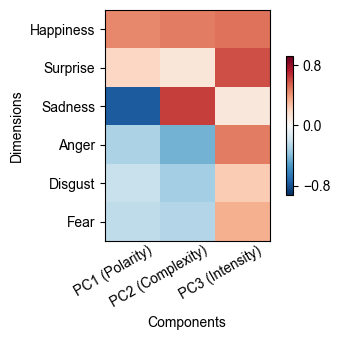

Human forrest:
Explained variance ratio: [0.45866067 0.23605802 0.1594916  0.0765148  0.05582819 0.01344671]
Explained variance ratio cumulated: [0.45866067 0.6947187  0.8542103  0.9307251  0.98655329 1.        ]


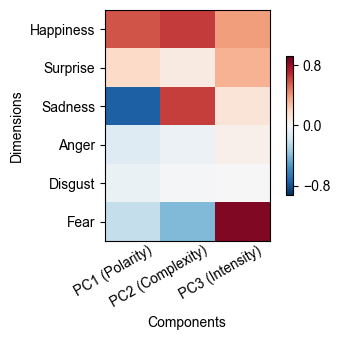

In [13]:
from sklearn.decomposition import PCA
import matplotlib
emos = ["Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear"]
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(preds_all)

# 创建PCA对象，设定要保留的主成分数量（例如：2个主成分）
pca = PCA(n_components=6)

# 使用PCA降维
X_pca_danmu = pca.fit_transform(preds_smoothed)

# 解释方差比例（每个主成分解释的方差占总方差的比例）
print('Danmu forrest:')
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Explained variance ratio cumulated:", 
      np.cumsum(pca.explained_variance_ratio_))

pca.components_[[0,3,4],:] = -pca.components_[[0,3,4],:]

matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(figsize=(4,3.5))
cax = ax.imshow(pca.components_.transpose()[:,:3],cmap='RdBu_r')
ax.set_aspect(0.7)
plt.xticks(np.arange(0.4,3.4,1),['PC1 (Polarity)', 'PC2 (Complexity)', 'PC3 (Intensity)'], rotation=30, ha='right')
plt.gca().tick_params(axis='x', pad=2)
plt.tick_params(axis='x', length=0)
plt.yticks(np.arange(6), emos)
plt.xlabel('Components')
plt.ylabel('Dimensions')
cbar = plt.colorbar(cax, shrink=0.6)
cbar.set_ticks([-0.8, 0.0, 0.8])
# max_lim = np.maximum(np.nanmax(pca.components_), -np.nanmin(pca.components_))
cax.set_clim([-0.921, 0.921])
# print(max_lim)
plt.tight_layout()
plt.savefig('figures/pca_scores_danmu_forrest_gump_PC3.svg', dpi=300, bbox_inches='tight')
plt.show()


pca = PCA(n_components=6)

# 使用PCA降维
X_pca_human = pca.fit_transform(ratings_smoothed)

# 解释方差比例（每个主成分解释的方差占总方差的比例）
print('Human forrest:')
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Explained variance ratio cumulated:", 
      np.cumsum(pca.explained_variance_ratio_))
pca.components_[[0,3,4],:] = -pca.components_[[0,3,4],:]

matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(figsize=(4,3.5))
cax = ax.imshow(pca.components_.transpose()[:,:3],cmap='RdBu_r')
ax.set_aspect(0.7)
plt.xticks(np.arange(0.4,3.4,1),['PC1 (Polarity)', 'PC2 (Complexity)', 'PC3 (Intensity)'], rotation=30, ha='right')
plt.gca().tick_params(axis='x', pad=2)
plt.tick_params(axis='x', length=0)
plt.yticks(np.arange(6), emos)
plt.xlabel('Components')
plt.ylabel('Dimensions')
cbar = plt.colorbar(cax, shrink=0.6)
cbar.set_ticks([-0.8, 0.0, 0.8])
# max_lim = np.maximum(np.nanmax(pca.components_), -np.nanmin(pca.components_))
cax.set_clim([-0.921, 0.921])
# print(max_lim)
plt.tight_layout()
plt.savefig('figures/pca_scores_ratings_forrest_gump_PC3.svg', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from scipy.stats import pearsonr
for i in range(3):
    # print(np.corrcoef(X_pca_danmu[:,i], X_pca_human[:,i])[0,1])
    r, p = pearsonr(X_pca_danmu[:,i], X_pca_human[:,i])
    print(r, p)

0.6717738279244219 0.0
0.5690372193251598 5.686650302546976e-308
0.3327146868613664 9.227423556635464e-94


Explained variance ratio: [0.54792509 0.22046489 0.1281383  0.06499654 0.02649904 0.01197614]


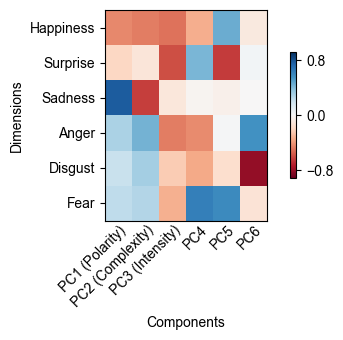

Explained variance ratio: [0.45866067 0.23605802 0.1594916  0.0765148  0.05582819 0.01344671]


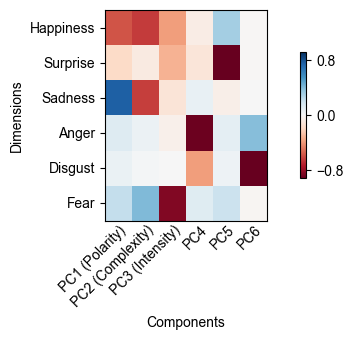

In [17]:
pca = PCA(n_components=6)

# 使用PCA降维
X_pca = pca.fit_transform(preds_smoothed)

# 解释方差比例（每个主成分解释的方差占总方差的比例）
print("Explained variance ratio:", pca.explained_variance_ratio_)

pca.components_[[0,3],:] = -pca.components_[[0,3],:]

matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(figsize=(5,3.5))
cax = ax.imshow(-pca.components_.transpose(),cmap='RdBu')
ax.set_aspect(1.3)
plt.xticks(np.arange(0.4,6.4,1),['PC1 (Polarity)', 'PC2 (Complexity)', 'PC3 (Intensity)', 'PC4', 'PC5', 'PC6'], rotation=45, ha='right')
plt.gca().tick_params(axis='x', pad=2)
plt.tick_params(axis='x', length=0)
plt.yticks(np.arange(6), emos)
plt.xlabel('Components')
plt.ylabel('Dimensions')
cbar = plt.colorbar(cax, shrink=0.6)
cbar.set_ticks([-0.8, 0.0, 0.8])
# max_lim = np.maximum(np.nanmax(pca.components_), -np.nanmin(pca.components_))
cax.set_clim([-0.921, 0.921])
# print(max_lim)
plt.tight_layout()
plt.savefig('figures/pca_scores_danmu_forrest_gump2.svg', dpi=300, bbox_inches='tight')
plt.show()

pca = PCA(n_components=6)

# 使用PCA降维
X_pca = pca.fit_transform(ratings_smoothed)

# 解释方差比例（每个主成分解释的方差占总方差的比例）
print("Explained variance ratio:", pca.explained_variance_ratio_)

pca.components_[[0,3],:] = -pca.components_[[0,3],:]

matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['font.family'] = 'Arial'
pca.components_[3,:] = -pca.components_[3,:]
fig, ax = plt.subplots(figsize=(7,3.5))
cax = ax.imshow(-pca.components_.transpose(),cmap='RdBu')
ax.set_aspect(1.3)
plt.xticks(np.arange(0.4,6.4,1),['PC1 (Polarity)', 'PC2 (Complexity)', 'PC3 (Intensity)', 'PC4', 'PC5', 'PC6'], rotation=45, ha='right')
plt.gca().tick_params(axis='x', pad=2)
plt.tick_params(axis='x', length=0)
plt.yticks(np.arange(6), emos)
plt.xlabel('Components')
plt.ylabel('Dimensions')
cbar = plt.colorbar(cax, shrink=0.6)
cbar.set_ticks([-0.8, 0.0, 0.8])
# max_lim = np.maximum(np.nanmax(pca.components_), -np.nanmin(pca.components_))
cax.set_clim([-0.921, 0.921])
# print(max_lim)
plt.tight_layout()
plt.savefig('figures/pca_ratings_forrest_gump2.svg', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
import os, json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.patches import Circle, FancyArrowPatch
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity

def _scott_bandwidth(X2):
    X2 = np.asarray(X2, float); n, d = X2.shape
    s = X2.std(axis=0, ddof=1).mean()
    return s * n ** (-1.0 / (d + 4))

def _hdr_thresholds(dens_grid, levels=(0.5, 0.8, 0.95), cell_area=1.0):
    f = dens_grid.ravel()
    idx = np.argsort(f)[::-1]
    mass = np.cumsum(f[idx]) * cell_area
    total = mass[-1]
    thr = []
    for a in levels:
        k = np.searchsorted(mass, a*total)
        k = min(max(k, 0), len(f)-1)
        thr.append(float(f[idx[k]]))
    return sorted(thr)

def _kde_on_grid(X2, xs, ys, bandwidth):
    XX, YY = np.meshgrid(xs, ys)
    grid = np.c_[XX.ravel(), YY.ravel()]
    kde = KernelDensity(kernel="gaussian", bandwidth=bandwidth)
    kde.fit(X2)
    logd = kde.score_samples(grid)
    dens = np.exp(logd).reshape(XX.shape)
    return XX, YY, dens

def _global_assign_and_transition(scores_all, centers6, n_samples_cum, eps=1e-6):
    X = np.asarray(scores_all, float)
    dif = X[:, None, :] - centers6[None, :, :]
    d2 = np.sum(dif*dif, axis=2)
    labels = d2.argmin(axis=1).astype(int)  # 0..5

    K = 6
    C = np.zeros((K, K), float)
    M = len(n_samples_cum) - 1
    for m in range(M):
        s, e = int(n_samples_cum[m]), int(n_samples_cum[m+1])
        if e - s <= 1: continue
        seg = labels[s:e]
        for a, b in zip(seg[:-1], seg[1:]):
            C[a, b] += 1.0
    P = C + eps
    P = P / P.sum(axis=1, keepdims=True)
    pi = (P.sum(axis=0) + eps)
    pi = pi / pi.sum()
    return labels, P, pi

def fit_six_emotion_anchors(
    scores_all, topk_frac=0.20, eps=1e-6
):

    X = np.asarray(scores_all, float)
    N, D = X.shape
    assert D == 6

    sums = X.sum(axis=1, keepdims=True) + eps
    purity = X / sums  
    centers = np.zeros((6, D), float)
    covs = np.zeros((6, D, D), float)
    counts = np.zeros(6, int)

    for k in range(6):
        mask = (X.argmax(axis=1) == k)
        Xk = X[mask]
        # if len(Xk) < min_n:
        #     idx = np.argsort(purity[:, k])[::-1]
        #     take = max(min_n, int(topk_frac * N))
        #     Xk = X[idx[:take]]

        m = len(Xk)
        # print(int(topk_frac * m))
        kk = int(topk_frac * m)
        idx2 = np.argsort(Xk[:, k])[::-1][:kk]
        Xk2 = Xk[idx2]

        centers[k] = Xk2.mean(axis=0)
        C = np.cov(Xk2, rowvar=False)
        C = 0.5*(C + C.T) + 1e-9*np.eye(D)
        covs[k] = C
        counts[k] = len(Xk2)
    return centers, covs, counts

EMO_NAMES  = ["Happiness", "Surprise", "Sadness", "Anger", "Disgust", "Fear"]
EMO_COLORS = ['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b']

In [19]:
centers6, covs6, counts = fit_six_emotion_anchors(
    scores_all,        # (N, 6)
    # purity_tau=1.0,   
    topk_frac=0.50 
    # min_n=500         
)
print("anchors per emotion:", counts)

anchors per emotion: [112913  37849  12221  13095    787   1218]


In [65]:
centers6_sim = np.array([[1.*np.max(scores_all[:,0]),0.,0.,0.,0.,0.],
                         [0.,1.*np.max(scores_all[:,1]),0.,0.,0.,0.],
                         [0.,0.,1.*np.max(scores_all[:,2]),0.,0.,0.],
                         [0.,0.,0.,1.*np.max(scores_all[:,3]),0.,0.],
                         [0.,0.,0.,0.,1.*np.max(scores_all[:,4]),0.],
                         [0.,0.,0.,0.,0.,1.*np.max(scores_all[:,5])]])

In [ ]:
random_state = 0
grid_res=400
bandwidth=None
bandwidth_scale=1.0
glow_sigma=6.0
levels=(0.5, 0.8, 0.95, 0.99)
    
rng = np.random.default_rng(random_state)

# 1) PCA(2) on pooled data
pca = PCA(n_components=2, svd_solver="full", random_state=random_state)
X2 = pca.fit_transform(scores_all)
C2 = pca.transform(centers6)  

# 3) KDE on a shared grid
pad = 0.01
xmin, xmax = X2[:,0].min(), X2[:,0].max()
ymin, ymax = X2[:,1].min(), X2[:,1].max()
dx, dy = xmax - xmin, ymax - ymin
xmin -= pad*dx; xmax = xmax+pad*dx+0.06; ymin -= pad*dy; ymax += pad*dy

xs = np.linspace(xmin, xmax, grid_res)
ys = np.linspace(ymin, ymax, grid_res)
cell_area = (xs[1]-xs[0]) * (ys[1]-ys[0])

if bandwidth is None:
    bandwidth = _scott_bandwidth(X2) * float(bandwidth_scale)

# XX, YY, dens = _kde_on_grid(X2, xs, ys, bandwidth)
# dens_blur = gaussian_filter(dens, sigma=glow_sigma)
# thr = _hdr_thresholds(dens, levels=levels, cell_area=cell_area)


In [80]:
with open('kde_prep2.pkl', 'rb') as f:
    kde_prep = pickle.load(f)
XX, YY, dens, dens_blur, thr = kde_prep['XX'], kde_prep['YY'], kde_prep['dens'], kde_prep['dens_blur'], kde_prep['thr']

In [81]:
print(xmin, xmax, ymin, ymax)
print(np.min(XX), np.max(XX), np.min(YY), np.max(YY))
xmin, xmax, ymin, ymax = np.min(XX), np.max(XX), np.min(YY), np.max(YY)

-9.375047871028144 4.643644358322811 -5.303414152688677 6.301404531999867
-10.059297490113975 5.267893977408642 -5.872277813702821 6.870268193014011


In [82]:
traj_lines = []
for i in range(102):
    seg = X2[n_samples_cum[i]: n_samples_cum[i+1]]
    traj_lines.append(seg)

In [83]:
levels=(0.5, 0.8, 0.95, 0.999)
thr = _hdr_thresholds(dens, levels=levels, cell_area=cell_area)

In [84]:
from matplotlib.colors import LinearSegmentedColormap
EMO_COLORS = ['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b']
EMO_COLORS_WHITE_BG = EMO_COLORS

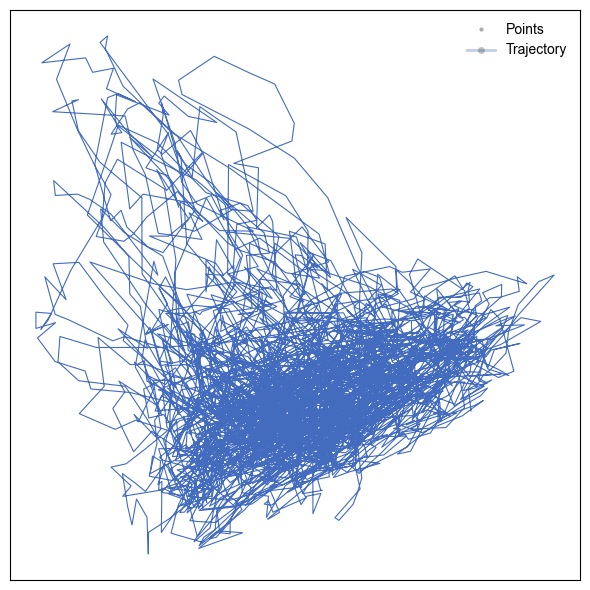

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(6, 6))

# === 你的散点 ===
ax.scatter(
    X2[:10, 0], X2[:10, 1],
    s=2.5, c="#333333", alpha=0.2,
    linewidths=0, zorder=0, rasterized=True
)

ax.scatter(
    X2[:10, 0], X2[:10, 1],
    s=1, c="#1A1A1A", alpha=0.4,
    linewidths=0, zorder=1, rasterized=True
)

# === 你的轨迹线 ===
traj_alpha = 0.9
ax.plot(
    seg[:, 0], seg[:, 1],
    lw=0.8, alpha=traj_alpha, color="#2E5CB8"
)

ax.set_xticks([])
ax.set_yticks([])

# ax.scatter(X2[idx,0], X2[idx,1],
#            s=2.5, c="#333333", alpha=0.2,
#            linewidths=0, zorder=0, rasterized=True)

# ax.scatter(X2[idx,0], X2[idx,1],
#            s=1, c="#1A1A1A", alpha=0.4,
#            linewidths=0, zorder=1, rasterized=True)

# for seg in traj_lines:
#     ax.plot(seg[:,0], seg[:,1], lw=0.8, alpha=traj_alpha, color="#2E5CB8")
    
# === 图例用 proxy artists 组合点+线 ===
traj_handle = Line2D(
    [0], [0],
    linestyle='-',
    linewidth=2,
    color="#2E5CB8",
    marker='o',
    markersize=5,
    markerfacecolor="#333333",
    markeredgewidth=0,
    alpha=0.3
)

bg_handle = Line2D(
    [0], [0],
    linestyle='',
    marker='o',
    markersize=3,
    markerfacecolor="#333333",
    markeredgewidth=0,
    alpha=0.4,
)

ax.legend(
    handles=[bg_handle, traj_handle],
    labels=["Points", "Trajectory"],
    frameon=False,
    loc="upper right"
)

plt.tight_layout()
plt.savefig('figures/fig6_legend.svg')
plt.show()


C:\Users\Windows\AppData\Local\Temp\ipykernel_27668\794900543.py:42: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for c in cs.collections:


[Peak cell] iy=166, ix=277, coord=(0.5814, -0.5709)


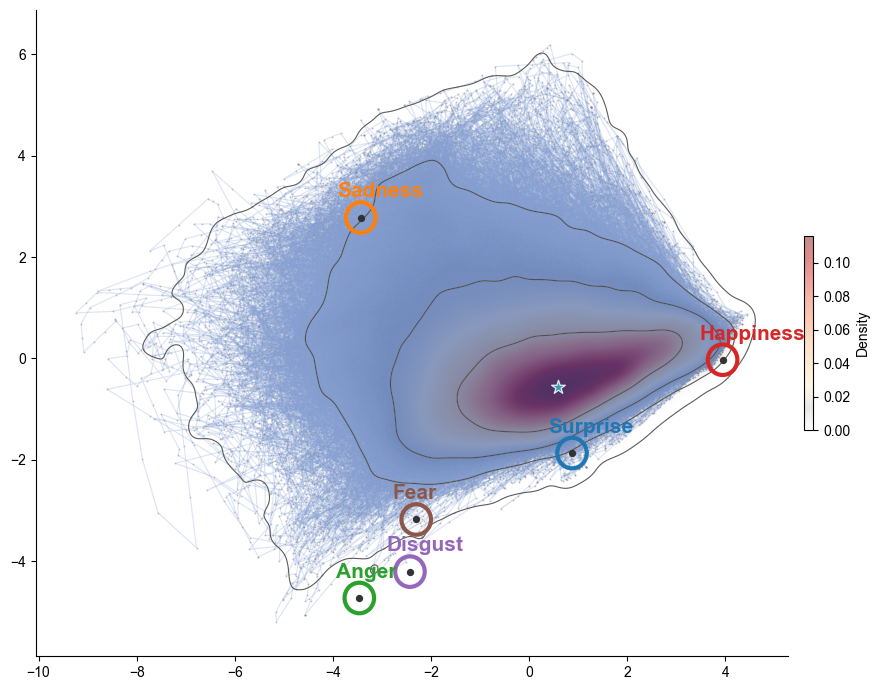

In [108]:
out_path_jpg='figures/emotion_dynamic_space2_withColorbar_sim.svg'
traj_alpha=0.3

fig = plt.figure(figsize=(9, 7), facecolor="white")
ax = plt.gca()
ax.set_facecolor("white")

D = np.log1p(dens)          # log

vmin = np.min(D)
vmax = np.max(D)

# 使用OrRd色系，从白色开始
colors = ['white', "#CCCBC9", '#FEE8C8', '#FDD49E', '#FDBB84', '#FC8D59', '#EF6548', '#D7301F', '#B30000', '#7F0000']
cmap = LinearSegmentedColormap.from_list('white_OrRd', colors)

# 或者更简单的版本，只使用几个关键颜色
# colors = ['white', '#FEE8C8', '#FDBB84', '#FC8D59', '#EF6548', '#D7301F', '#B30000']
# cmap = LinearSegmentedColormap.from_list('white_OrRd_simple', colors)

idx = np.arange(len(X2))
ax.scatter(X2[idx,0], X2[idx,1],
           s=2.5, c="#333333", alpha=0.2,
           linewidths=0, zorder=0, rasterized=True)

ax.scatter(X2[idx,0], X2[idx,1],
           s=1, c="#1A1A1A", alpha=0.4,
           linewidths=0, zorder=1, rasterized=True)

for seg in traj_lines:
    ax.plot(seg[:,0], seg[:,1], lw=0.8, alpha=traj_alpha, color="#2E5CB8")
    
im = ax.imshow(
    D, extent=(xmin, xmax, ymin, ymax), origin="lower",
    cmap=cmap, vmin=vmin, vmax=vmax,
    alpha=0.45, interpolation="bilinear", aspect="auto", zorder=2
)

# 改为深色等高线
for t in thr:
    cs = ax.contour(XX, YY, dens, levels=[t], colors="#333333", linewidths=0.8, alpha=0.8)
    for c in cs.collections:
        c.set_path_effects([pe.Stroke(linewidth=0.6, foreground="#FFFFFF88"), pe.Normal()])

center_mass = X2.mean(axis=0)
# 定义在白色背景下可见的情绪颜色
# EMO_COLORS_WHITE_BG = ['#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00', '#FFFF33']

for k, (cx, cy) in enumerate(C2):
    ring = Circle((cx, cy), radius=0.22*max(dx,dy)/10,
                    facecolor='none', edgecolor=EMO_COLORS_WHITE_BG[k], linewidth=3.0, zorder=3)
    ax.add_patch(ring)
    ax.scatter([cx], [cy], s=18, color="#333333", zorder=4)
    #v = np.array([cx, cy]) - center_mass
    #v = v / (np.linalg.norm(v) + 1e-9)
    lx, ly = cx-0.035*dx, cy + 0.035*dy#*v[1]
    txt = ax.text(lx, ly, EMO_NAMES[k],
                    color=EMO_COLORS_WHITE_BG[k], fontsize=15, weight="bold", zorder=5)
    # txt.set_path_effects([pe.Stroke(linewidth=1.1, foreground="#FFFFFFCC"), pe.Normal()])

ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
# ax.set_xticks([]); ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 寻找 dens 的全局最大栅格索引（注意：dens.shape = (ny, nx)）
iy, ix = np.unravel_index(np.argmax(dens), dens.shape)   # 行(y)、列(x)索引
x_peak, y_peak = XX[iy, ix], YY[iy, ix]                  # 映射到坐标系
print(f"[Peak cell] iy={iy}, ix={ix}, coord=({x_peak:.4f}, {y_peak:.4f})")

# 在图上标注峰值（小圆环+星标）
peak_color = '#3B9AB2'  # 亮青蓝色，与红橙色系形成强对比

ax.scatter([x_peak], [y_peak],
           s=108, marker='*',
           color=peak_color,
           edgecolor='#FFFFFFDD', linewidth=0.9, zorder=6)
# ax.scatter([x_peak], [y_peak], s=58, marker='*', color='white',
#            edgecolor='#000000AA', linewidth=1.5, zorder=6)

cbar = plt.colorbar(im, ax=ax, fraction=0.04, pad=0.02, shrink=0.3)
cbar.set_label("Density", color="black")
cbar.ax.yaxis.set_tick_params(color="black")
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')
# ax.set_aspect('equal')
plt.tight_layout()
plt.savefig(out_path_jpg, dpi=300, bbox_inches='tight')

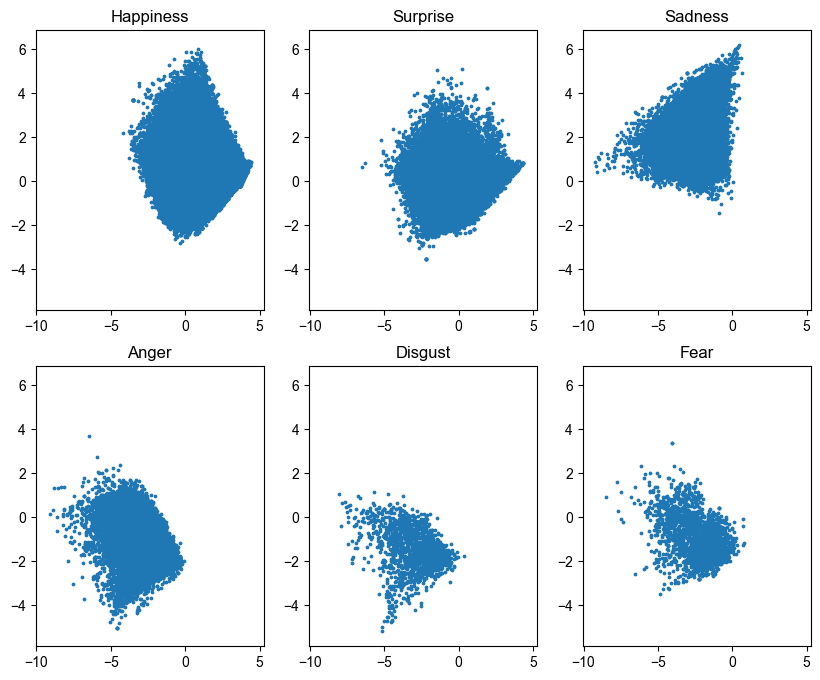

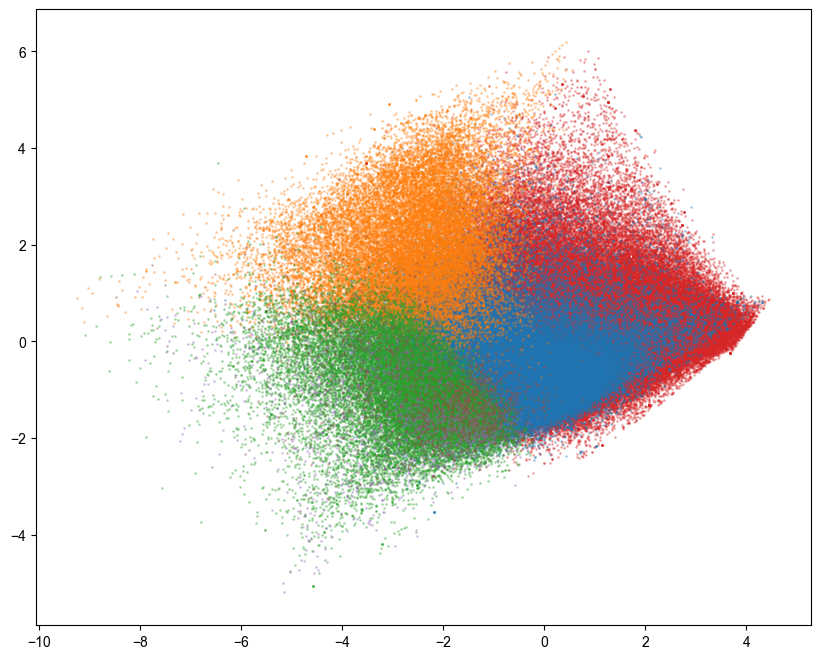

In [88]:
plt.figure(figsize=(10,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    use_inds = np.where(np.argmax(scores_all, axis=1)==i)[0]    
    plt.scatter(X2[use_inds, 0], X2[use_inds, 1], s=3)
    plt.xlim(xmin, xmax); plt.ylim(ymin, ymax)
    plt.title(EMO_NAMES[i])
plt.show()

plt.figure(figsize=(10,8))
for i in range(6):
    use_inds = np.where(np.argmax(scores_all, axis=1)==i)[0]    
    plt.scatter(X2[use_inds, 0], X2[use_inds, 1], s=1, c=EMO_COLORS[i], alpha=0.3)
plt.xlim(xmin, xmax); plt.ylim(ymin, ymax)
plt.show()

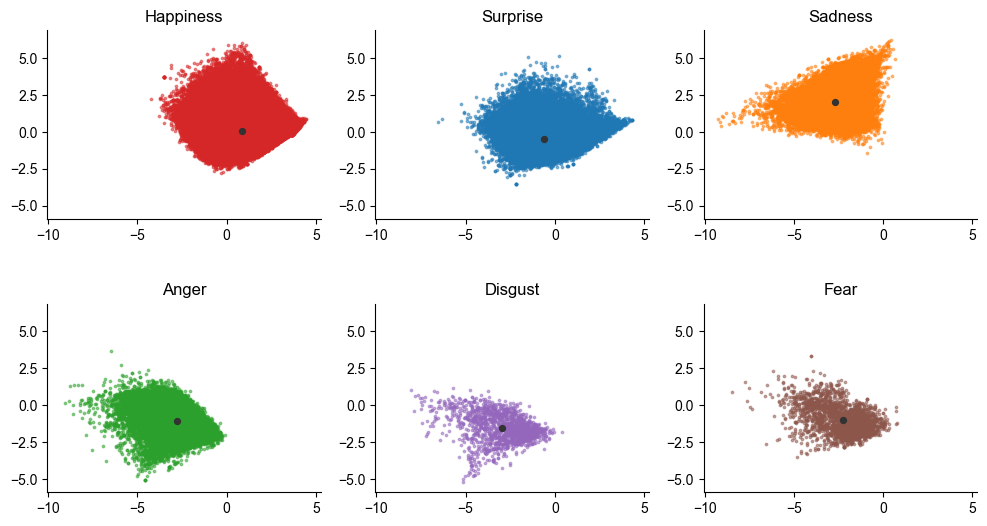

In [ ]:
fig, axes = plt.subplots(
    2, 3,
    figsize=(12, 6),
    gridspec_kw={'hspace': 0.45}  # 这里直接控制两行之间的间距
)

for i, ax in enumerate(axes.flat):
    use_inds = np.where(np.argmax(scores_all, axis=1) == i)[0]
    ax.scatter(X2[use_inds, 0], X2[use_inds, 1], s=3, c=EMO_COLORS[i], alpha=0.5)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_title(EMO_NAMES[i])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    cx, cy = np.mean(X2[use_inds, 0]), np.mean(X2[use_inds, 1])
    ax.scatter([cx], [cy], s=18, color="#333333", zorder=4)
plt.show()

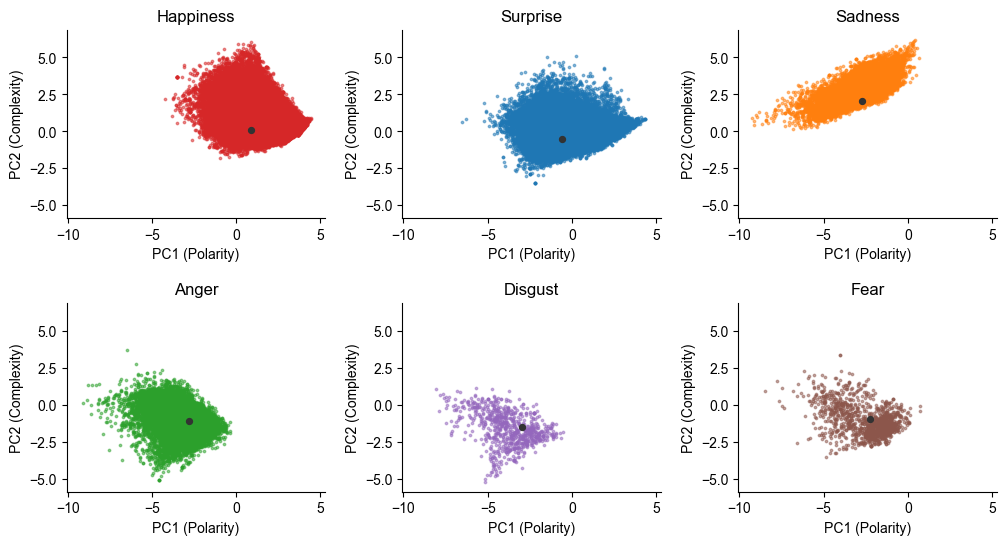

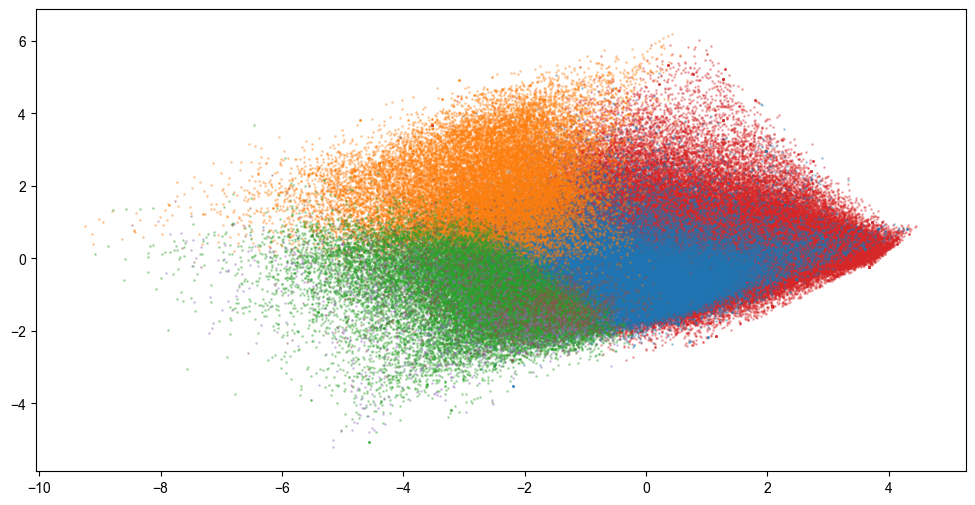

In [129]:
fig, axes = plt.subplots(
    2, 3,
    figsize=(12, 6),
    gridspec_kw={'hspace': 0.45, 'wspace': 0.3}  # 这里直接控制两行之间的间距
)

for i, ax in enumerate(axes.flat):
    use_inds = np.where(np.argmax(scores_all, axis=1) == i)[0]
    thr = np.median(scores_all[use_inds,i])
    X2_use = X2[use_inds,:][scores_all[use_inds,i]>thr,:]
    ax.scatter(X2_use[:, 0], X2_use[:, 1], s=3, c=EMO_COLORS[i], alpha=0.5)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_title(EMO_NAMES[i])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('PC1 (Polarity)')
    ax.set_ylabel('PC2 (Complexity)')
    cx, cy = np.mean(X2[use_inds, 0]), np.mean(X2[use_inds, 1])
    ax.scatter([cx], [cy], s=18, color="#333333", zorder=4)
plt.savefig('figures/emo_points.jpg')
plt.show()

plt.figure(figsize=(12,6))
for i in range(6):
    use_inds = np.where(np.argmax(scores_all, axis=1) == i)[0]
    thr = np.median(scores_all[use_inds,i])
    X2_use = X2[use_inds,:][scores_all[use_inds,i]>thr,:]  
    plt.scatter(X2[use_inds, 0], X2[use_inds, 1], s=1, c=EMO_COLORS[i], alpha=0.3)
plt.xlim(xmin, xmax); plt.ylim(ymin, ymax)
plt.show()

In [73]:
cluster_inds = np.argmax(scores_all, axis=1)

In [74]:
scores_ds = scores_all[::10,:]
cluster_ds = cluster_inds[::10]

In [75]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_embedded_ds = tsne.fit_transform(scores_ds)

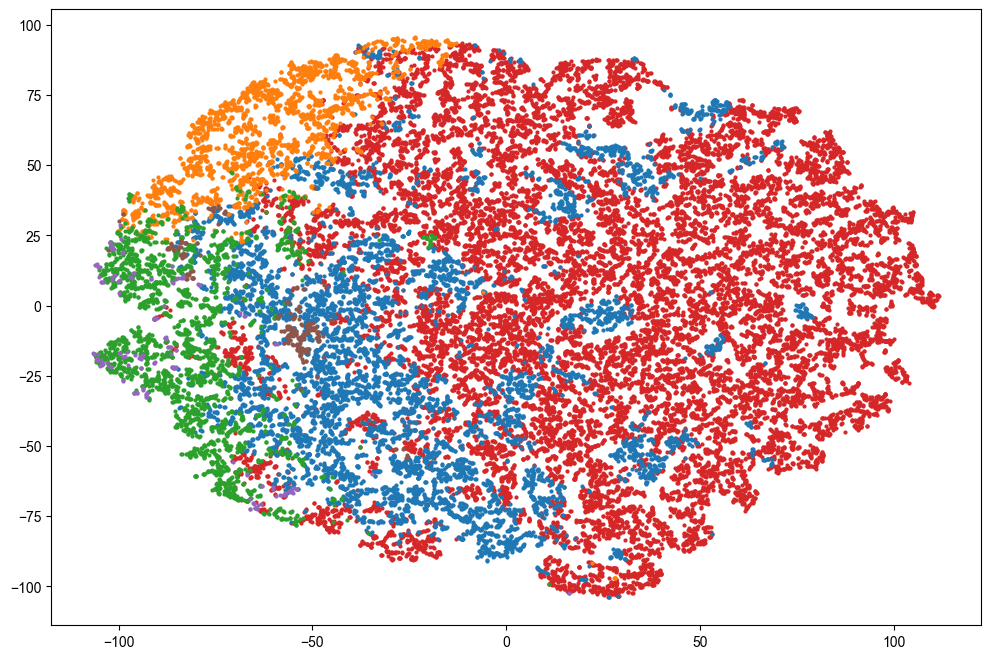

In [78]:
plt.figure(figsize=(12,8))
for i in range(6):
    plt.scatter(X_embedded_ds[cluster_ds==i,0], X_embedded_ds[cluster_ds==i,1], c=EMO_COLORS[i], s=4)
plt.show()